In [41]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd


In [42]:
PROJECT_ROOT = os.path.abspath("..")
PROCESSED_PATH = os.path.join(PROJECT_ROOT, "data", "processed")
MODELS_PATH = os.path.join(PROJECT_ROOT, "models")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_val_path = os.path.join(PROCESSED_PATH, "X_val.npy")
y_val_path = os.path.join(PROCESSED_PATH, "y_val.npy")


In [43]:
X_val = np.load(X_val_path).astype(np.float32)
y_val = np.load(y_val_path).astype(np.int64)
if len(X_val.shape) == 3:
    X_val = np.expand_dims(X_val, axis=1)
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [44]:
X_val = np.load(X_val_path).astype(np.float32)
y_val = np.load(y_val_path).astype(np.int64)
if len(X_val.shape) == 3:
    X_val = np.expand_dims(X_val, axis=1)
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [45]:
class AdvancedEmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.25),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.25),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.25)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(), nn.BatchNorm1d(256), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.fc_layers(self.conv_layers(x))


In [46]:
num_classes = len(np.unique(y_val))
model = AdvancedEmotionCNN(num_classes).to(DEVICE)
model.load_state_dict(torch.load(os.path.join(MODELS_PATH, "emotion_cnn_best.pt")))
model.eval()

AdvancedEmotionCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.25, inplace=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True,

In [47]:
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        outputs = model(xb)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [48]:
val_accuracy = np.sum(all_preds==all_labels)/len(all_labels)
print({"val_accuracy": float(val_accuracy)})

{'val_accuracy': 0.8924528301886793}


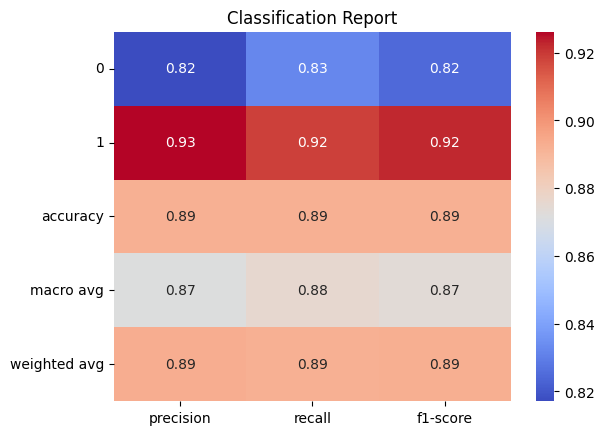

In [49]:
report = classification_report(all_labels, all_preds, output_dict=True)
report_df = pd.DataFrame(report).iloc[:-1, :].T
sns.heatmap(report_df, annot=True, cmap='coolwarm')
plt.title("Classification Report")
plt.show()

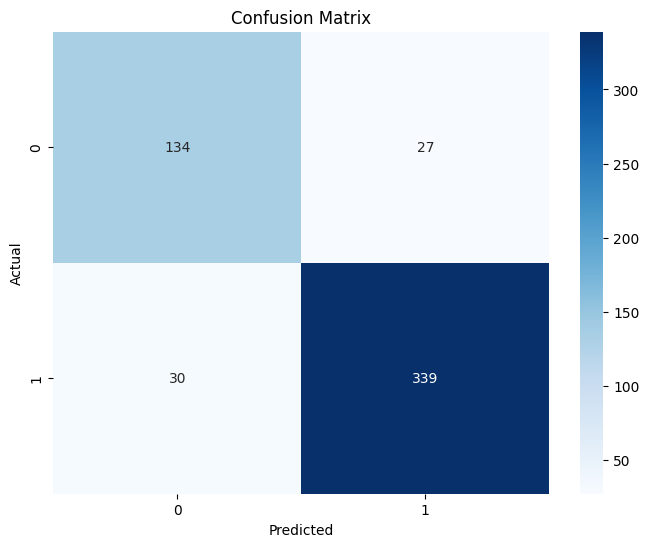

In [50]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

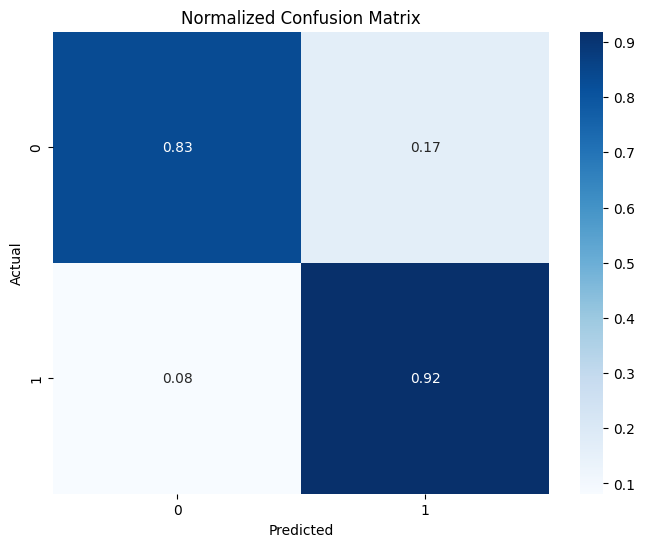

In [51]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

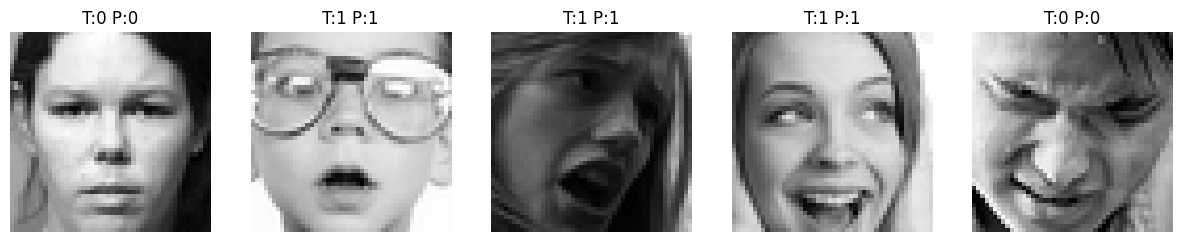

In [52]:
correct_idx = np.where(all_preds==all_labels)[0]
fig, axes = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    axes[i].imshow(X_val[correct_idx[i]].squeeze(), cmap='gray')
    axes[i].set_title(f"T:{all_labels[correct_idx[i]]} P:{all_preds[correct_idx[i]]}")
    axes[i].axis('off')
plt.show()

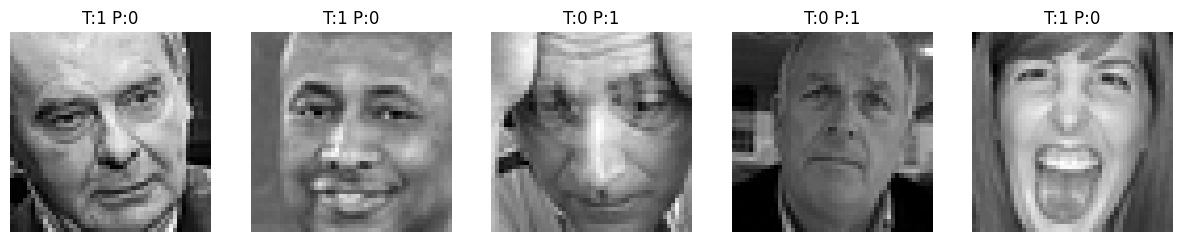

In [53]:
mis_idx = np.where(all_preds!=all_labels)[0]
fig, axes = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    axes[i].imshow(X_val[mis_idx[i]].squeeze(), cmap='gray')
    axes[i].set_title(f"T:{all_labels[mis_idx[i]]} P:{all_preds[mis_idx[i]]}")
    axes[i].axis('off')
plt.show()

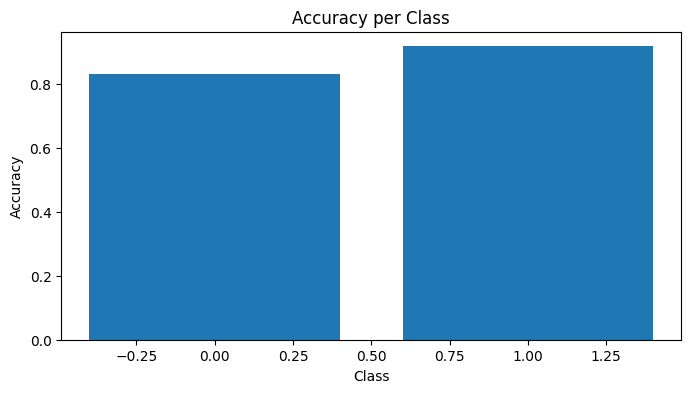

In [54]:
labels = np.unique(y_val)
class_acc = [np.sum((all_labels==cls)&(all_preds==cls))/np.sum(all_labels==cls) for cls in labels]
plt.figure(figsize=(8,4))
plt.bar(labels, class_acc)
plt.title("Accuracy per Class")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.show()

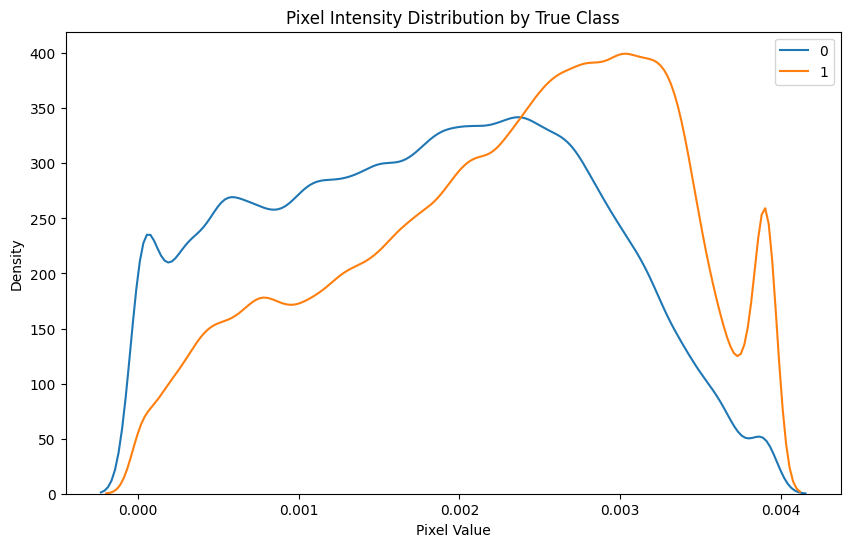

In [55]:
plt.figure(figsize=(10,6))
for cls in labels:
    pixels = X_val[all_labels==cls].reshape(-1)
    sns.kdeplot(pixels, label=str(cls))
plt.title("Pixel Intensity Distribution by True Class")
plt.xlabel("Pixel Value")
plt.ylabel("Density")
plt.legend()
plt.show()

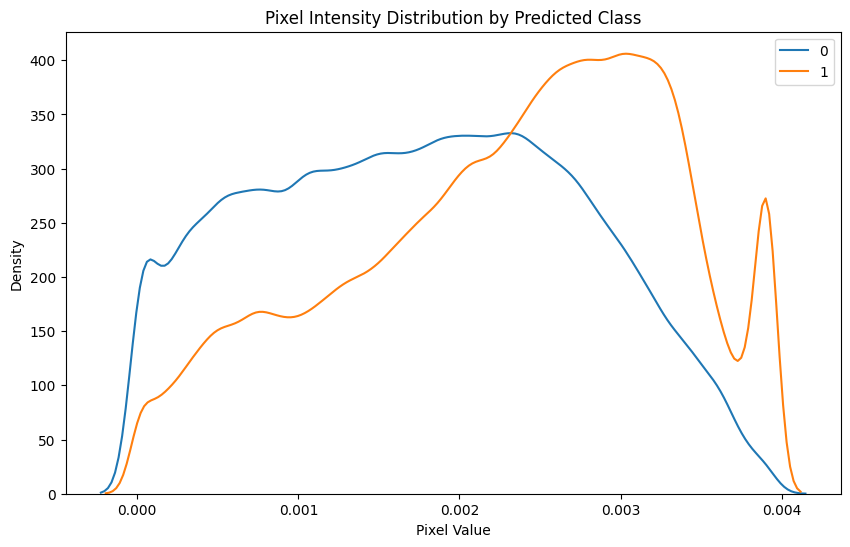

In [56]:
plt.figure(figsize=(10,6))
for cls in labels:
    pixels = X_val[all_preds==cls].reshape(-1)
    sns.kdeplot(pixels, label=str(cls))
plt.title("Pixel Intensity Distribution by Predicted Class")
plt.xlabel("Pixel Value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [57]:
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df_no_diag = cm_df.copy()
for i in range(len(labels)):
    cm_df_no_diag.iloc[i, i] = 0
top_confused = cm_df_no_diag.stack().sort_values(ascending=False)[:5]
print(top_confused)


1  0    30
0  1    27
   0     0
1  1     0
dtype: int64
